# Управление с непрерывными действиями (Continuous Control) (<span style="color: green">10 баллов за основную часть + 5 баллов за бонусную часть</span>)

#### Дедлайн (жёсткий) задания: 04.05.2025,  UTC+3.

#### При сдаче задания нужно  поместить в архив данный файл и папки с логами и видео, сохраняя относительные пути, и послать архив в систему сдачи.

### <span style="color: red"> Если работа была списана и/или сделана LLM, то за работу ставится 0 баллов. </span> 

# Работа выполнена: Лотфуллин Камиль Рашитович, М05-401.

В этом домашнем задании предлагается решить задачу управления с непрерывными действиями, используя алгоритмы:

- **Twin Delayed DDPG (TD3)** (**Раздел 6.1.6 (Алгоритм 23)**)
- **Soft Actor-Critic (SAC)** (**Раздел 6.2.4 (Алгоритм 24)**)

Оба алгоритма являются off-policy и считаются одними из наиболее эффективных для задач управления в непрерывном пространстве действий. Они основаны на базовом алгоритме **Deep Deterministic Policy Gradient (DDPG)** (**Раздел 6.1.5 (Алгоритм 22)**), который можно представить как "DQN с отдельной нейросетью для аппроксимации жадной политики". Основные отличия заключаются в различных стабилизационных приёмах:

- TD3 обучает детерминированную политику, тогда как SAC использует стохастическую политику. Это означает, что в SAC достаточно просто сэмплировать действия из политики для исследования, в то время как в TD3 необходимо вручную добавлять шум к действиям.
- TD3 добавляет к действиям обрезанный шум (clipped noise) при расчёте целевых значений, что помогает бороться с переоценкой. SAC использует формализм максимальной энтропии и добавляет бонус за энтропию в функцию ценности, поощряя более разнообразные действия.

In [ ]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import trange
from queue import deque
from pathlib import Path
from IPython.display import HTML

import gymnasium as gym
from gymnasium.wrappers import RecordVideo

import torch
import torch.nn as nn
from torch.distributions import Normal

from logger import TensorboardSummaries as Summaries

In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cpu'

## Среда

Сначала мы создадим экземпляр среды.

In [3]:
env = gym.make("BipedalWalker-v3", render_mode="rgb_array")

env.reset()

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

print("Размерность вектора состояний dim =", state_dim)
print("n_actions =", action_dim)

Размерность вектора состояний dim = 24
n_actions = 4


Посмотрим на среду.

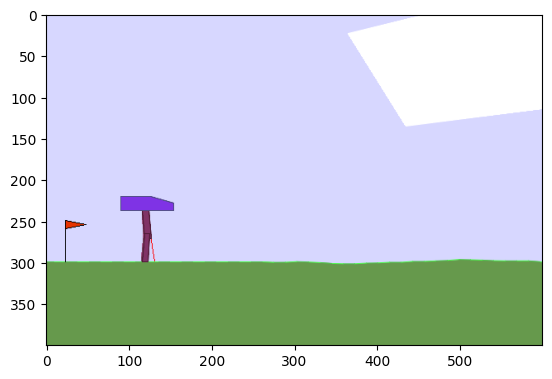

In [4]:
plt.imshow(env.render());

Давайте посмотрим на случайную политику и посмотрим, как это выглядит.

In [5]:
class RandomActor():
    def get_action(self, states):
        assert len(states.shape) == 1, "Не работает с батчами"
        return env.action_space.sample()

In [6]:
s, _ = env.reset()
rewards_per_step = []
actor = RandomActor()

for i in range(10000):
    a = actor.get_action(s)
    s, r, terminated, truncated, _ = env.step(a)

    rewards_per_step.append(r)

    if terminated or truncated:
        s, _ = env.reset()
        print("done: ", i)

done:  1599
done:  3199
done:  3287
done:  4887
done:  5022
done:  5078
done:  5182
done:  5311
done:  5371
done:  5417
done:  5482
done:  5566
done:  7166
done:  7303
done:  7385
done:  8985
done:  9039
done:  9088
done:  9145
done:  9209
done:  9260
done:  9355


В основном, каждый эпизод длится **1600 шагов** &mdash; это ограничение по времени, после которого происходит завершение эпизода. Однако иногда эпизод завершается раньше, если симуляция "понимает", что агент, например, **упал** или **разбился** &mdash; то есть ситуация явно неудачная для продолжения.

Посмотрим, что мы получаем при использовании случайной политики.

In [7]:
def evaluate(env, actor, n_games=1, t_max=1600):
    '''
    Запускает n_games эпизодов и возвращает массив наград.

    Возвращает
    -------
    rewards: np.array
        Массив наград
    '''
    rewards = []

    for _ in range(n_games):
        s, _ = env.reset()
        R = 0

        for _ in range(t_max):

            ### Ваш код
            action = actor.get_action(s)
            ###

            assert (action.max() <= 1).all() and  (action.min() >= -1).all()

            s, r, terminated, truncated, _ = env.step(action)

            R += r

            if terminated or truncated:
                break

        rewards.append(R)

    return np.array(rewards)

In [8]:
with RecordVideo(
    env = gym.make("BipedalWalker-v3", render_mode="rgb_array"),
    video_folder="./videos_test"
) as env_monitor:
    evaluate(env_monitor, actor, n_games=1, t_max=300)

/Users/lotfullin/Experiments/ReinforcedLearning/Непрерывное_управление/.venv/lib/python3.9/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /Users/lotfullin/Experiments/ReinforcedLearning/Непрерывное_управление/videos_test folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


In [9]:
video_paths = sorted([s for s in Path('videos_test').iterdir() if s.suffix == '.mp4'])
video_path = video_paths[-1]

data_url = str(video_path)

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(data_url))

# Буфер

То же самое, что и в DQN. Вы можете просто скопировать код из вашего задания по DQN.

#### Напомним интерфейс:
* `exp_replay.add(obs, act, rw, next_obs, done)`  &mdash; сохраняет кортеж (s,a,r,s',done) в буфер.
* `exp_replay.sample(batch_size)` &mdash; возвращает наблюдения, действия, награды, следующие наблюдения и is_done для `batch_size` случайных сэмплов.
* `len(exp_replay)` &mdash; возвращает количество элементов, хранящихся в буфере на данный момент.

In [10]:
class ReplayBuffer(object):
    def __init__(self, size):
        """
        Создаёт буфер реплеев.
        """
        self._storage = deque(maxlen=size)
        self._maxsize = size

    def __len__(self):
        return len(self._storage)

    def add_random(self, obs_t, action, reward, obs_tp1, done):
        '''
        Убедитесь, что _storage не превзойдёт по размерам _maxsize.
        Убедитесь, что FIFO правило выполняется: старейшие прецеденты должны удаляться раньше всех.
        '''
        data = (obs_t, action, reward, obs_tp1, done)
        self._storage.append(data)

    def sample_random(self, batch_size):
        """
        Сэмплирование батча переходов.

        Возвращает
        -------
        obs_batch: np.array
            батч наблюдений (состояний)
        act_batch: np.array
            батч действий, выполненных на основе obs_batch
        rew_batch: np.array
            награды, полученные в качестве результата выполнения act_batch
        next_obs_batch: np.array
            следующие наблюдения (состояния), полученные после выполнения act_batch
        done_mask: np.array
            done_mask[i] = 1, если выполнение act_batch[i] повлекло
            окончание эпизода и 0 иначе.
        """

        #< случайно сгенерировать batch_size индексов сэмплов в буфере >
        indices = np.random.choice(len(self._storage), batch_size, replace=False)

        # собрать <s,a,r,s',done> для каждого индекса
        states, actions, rewards, next_states, dones = [], [], [], [], []
        for idx in indices:
            sample = self._storage[idx]
            states.append(sample[0])
            actions.append(sample[1])
            rewards.append(sample[2])
            next_states.append(sample[3])
            dones.append(sample[4])
        # < states > , < actions >, < rewards >,  < next_states >, < is_done >
        return (
            np.array(states),
            np.array(actions),
            np.array(rewards),
            np.array(next_states),
            np.array(dones)
        )

Протестим.

In [11]:
exp_replay = ReplayBuffer(10)

for _ in range(30):
    exp_replay.add_random(env.reset()[0], env.action_space.sample(), 1.0, env.reset()[0], done=False)

obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample_random(5)

assert len(exp_replay) == 10, "Размер буфера должен быть равен 10, потому что это максимальная вместимость"

Функция для записи в буфер.

In [12]:
def play_and_record(initial_state, agent, env, exp_replay, n_steps=1):
    """
    Играется в среде ровно n шагов и записывается каждая пятёрка (s, a, r, s', done) в буффер.

    Возвращает
    -------
        sum_rewards: float
            суммарную награду за n шагов.
        s: float
            состояние, в котором осталась среда.
    """
    s = initial_state
    sum_rewards = 0

    for t in range(n_steps):

        ### Ваш код
        a = agent.get_action(s)
        ###

        ns, r, terminated, truncated, _ = env.step(a)

        exp_replay.add_random(s, a, r, ns, terminated)

        s = env.reset()[0] if terminated or truncated else ns

        sum_rewards += r

    return sum_rewards, s

# Критик

Давайте начнём с модели критика &mdash; она одинаковая для **TD3** и **SAC**. С одной стороны, он будет приближать оптимальную функцию $Q^*(s, a)$, а с другой &mdash; оценивать текущего актора $\pi$, то есть рассматриваться как 
$Q^{\pi}(s, a)$. Этот критик принимает на вход как состояние $s$, так и действие $a,$ а на выходе выдаёт скалярное значение.

Важно: если модель возвращает скаляр на выходе, хорошей практикой является применение .squeeze(), чтобы избежать неожиданного broadcast-а, поскольку тензор формы [batch_size, 1] может автоматически расширяться при операциях с другими тензорами.

Рекомендуемая архитектура &mdash; полносвязная нейронная сеть (MLP) с тремя слоями.

<span style="color: green"> __(1 балл)__ </span>

In [13]:
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super().__init__()

        ### Ваш код
        self.net = nn.Sequential(
            nn.Linear(state_dim + action_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
        ###

    def forward(self, states, actions):

        ### Ваш код
        x = torch.cat([states, actions], dim=-1)
        output = self.net(x)
        ###

        return output

    def get_qvalues(self, states, actions):
        '''
        Возвращает qvalues

        Параметры
        ----------
        states: torch.tensor [batch_size x features]
        actions: torch.tensor [batch_size x actions_dim]

        Возвращает
        -------
        qvalues: torch.tensor [batch_size]
        '''
        ### Ваш код
        qvalues = self.forward(states, actions).squeeze(-1)
        ###

        assert len(qvalues.shape) == 1 and qvalues.shape[0] == states.shape[0]

        return qvalues

# TD3

In [14]:
env = gym.make("BipedalWalker-v3", render_mode="rgb_array")
env = Summaries(env, "TD3")

Определим политику, или актора $\pi$. Необходимо смоделировать детерминированную политику. То есть, модель должна возвращать `action_dim` чисел в диапазоне $[-1, 1]$. К сожалению, детерминированные политики могут вызывать проблемы со стабильностью и исследованием, поэтому нам потребуется реализовать три "режима" работы этой политики:

1. Первый режим &mdash; **жадный** &mdash; это просто прямой проход через сеть. Он будет использоваться для обучения актора.
2. Второй режим &mdash; **режим исследования** &mdash; когда нужно добавить шум (например, гауссовский), чтобы собирать более разнообразные данные.
3. Третий режим &mdash; **"обрезанный шум"** &mdash; используется при расчёте целевого значения для критика. Здесь мы хотим добавить шум к выходу актора, но не слишком сильный, поэтому используем обрезанный шум:
$$\pi_{\theta}(s) + \varepsilon, \quad \varepsilon = \operatorname{clip}(\epsilon, -0.5, 0.5), \quad \epsilon \sim \mathcal{N}(0, \sigma^2 I)$$

Рекомендуемая архитектура &mdash; полносвязная нейросеть (MLP) с тремя слоями.

<span style="color: green"> __(2 балла)__ </span>

In [15]:
class TD3_Actor(nn.Module):
    def __init__(self, state_dim, action_dim, device, hidden_dim=256):
        super().__init__()
        self.device = device

        ### Ваш код
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim),
            nn.Tanh()
        )
        ###

    def forward(self, state):
        ### Ваш код
        output = self.net(state)
        ###
        return output

    def get_best_action(self, states):
        '''
        Используется для оптимизации актора.
        Требуется, чтобы действия были дифференцируемыми по параметрам модели.

        Параметры
        ----------
        states: torch.tensor [batch_size x features]

        Возвращает
        -------
        actions: torch.tensor [batch_size x actions_dim]
        '''
        ### Ваш код
        actions = self.forward(states)
        ###

        return actions

    def get_action(self, states, std_noise=0.1):
        '''
        Используется для взаимодействия с окружающей средой и сбора данных.
        Поэтому к действиям необходимо добавлять шум.

        Параметры
        ----------
        states: np.array [batch_size x features]
        std_noise: float

        Возвращает
        -------
        actions: np.array [batch_size x actions_dim]
        '''
        # Градиенты тут не нужны, так как используется только для взаимодействия
        with torch.no_grad():

            ### Ваш код
            states = torch.tensor(states, device=self.device)
            # dist = Normal(0, std_noise)
            actions = self.forward(states)
            actions += torch.normal(0, std_noise, size=actions.shape, device=self.device)
            actions = torch.clamp(actions, -1., 1.)

            actions = actions.cpu().numpy()
            ###

            assert actions.max() <= 1. and actions.min() >= -1,\
                "Действия должны находиться в диапазоне [-1, 1]"
        return actions


    def get_target_action(self, states, std_noise=0.2, clip_eta=0.5):
        '''
        Используется для генерации целевых значений при обучении критика.
        Возвращает действия с добавленным "обрезанным шумом".

        Параметры
        ----------
        states: torch.tensor [batch_size x features]
        std_noise: float
        clip_eta: float

        Возвращает
        -------
        actions: torch.tensor [batch_size x actions_dim]
        '''
        # Градиенты тут также не нужны, используется только для генерации целевых значений
        with torch.no_grad():

            ### Ваш код
            actions = self.forward(states)
            raw_noise = Normal(0, std_noise).sample(actions.shape).to(self.device)
            noise = torch.clamp(raw_noise, -clip_eta, clip_eta)
            actions = actions + noise
            actions = torch.clamp(actions, -1., 1.)
            ###

            assert actions.max() <= 1. and actions.min() >= -1,\
                "Действия должны находиться в диапазоне [-1, 1]"
        return actions

Протестим.

In [16]:
exp_replay = ReplayBuffer(2000)
actor = TD3_Actor(state_dim, action_dim, DEVICE).to(DEVICE)

state, _ = env.reset()
play_and_record(state, actor, env, exp_replay, n_steps=1000)

assert len(exp_replay) == 1000, \
    "play_and_record должен был добавить ровно 1000 шагов, но вместо этого добавил %i" % len(exp_replay)

is_dones = list(zip(*exp_replay._storage))[-1]

for _ in range(100):
    obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample_random(10)

    assert obs_batch.shape == next_obs_batch.shape == (10,) + (state_dim,), \
        "Батчи наблюдений и следующих состояний должны иметь форму (10, %d)" % state_dim

    assert act_batch.shape == (10, action_dim), \
        "Батч действий должен иметь форму (10, 8), но вместо этого: %s" % str(act_batch.shape)

    assert reward_batch.shape == (10,), \
        "Батч наград должен иметь форму (10,), но вместо этого: %s" % str(reward_batch.shape)

    assert is_done_batch.shape == (10,), \
        "Батч is_done должен иметь форму (10,), но вместо этого: %s" % str(is_done_batch.shape)

    assert [int(i) in (0, 1) for i in is_dones], \
        "is_done должен быть строго True или False (или 1/0)"

print("Отлично!")

Отлично!


## Инициализация

In [17]:
max_buffer_size = 10**6
exp_replay = ReplayBuffer(max_buffer_size)

In [18]:
actor = TD3_Actor(state_dim, action_dim, DEVICE).to(DEVICE)
critic1 = Critic(state_dim, action_dim).to(DEVICE)
critic2 = Critic(state_dim, action_dim).to(DEVICE)

Чтобы стабилизировать обучение, нам понадобятся целевые сети &mdash; медленно обновляемые копии наших моделей.

In [19]:
target_actor = TD3_Actor(state_dim, action_dim, DEVICE).to(DEVICE)
target_critic1 = Critic(state_dim, action_dim).to(DEVICE)
target_critic2 = Critic(state_dim, action_dim).to(DEVICE)

target_actor.load_state_dict(actor.state_dict())
target_critic1.load_state_dict(critic1.state_dict())
target_critic2.load_state_dict(critic2.state_dict());

В задачах с непрерывным управлением целевые сети обычно обновляются с использованием экспоненциального сглаживания:
$$\theta^{-} \leftarrow \tau \theta + (1 - \tau) \theta^{-},$$
где $\theta^{-}$ &mdash; веса дополнительной сети, $\theta$ &mdash; текущие параметры модели, а $\tau$ &mdash; гиперпараметр (коэффициент обновления).

In [20]:
def update_target_networks(model, target_model, tau=0.005):
    for param, target_param in zip(model.parameters(), target_model.parameters()):
          target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

Наконец, у нас будет три отдельных процедуры оптимизации для обучения трёх моделей, так что давайте поприветствуем наших трёх Адамов:

In [21]:
opt_actor = torch.optim.Adam(actor.parameters(), lr=3e-4)
opt_critic1 = torch.optim.Adam(critic1.parameters(), lr=3e-4)
opt_critic2 = torch.optim.Adam(critic2.parameters(), lr=3e-4)

Функция для оптимизации.

In [22]:
def optimize(name, model, optimizer, loss, n_iterations, max_grad_norm=10):
    '''
    Выполняет один шаг оптимизации, ограничивает норму градиента значением max_grad_norm
    и логирует всё в TensorBoard.
    '''
    loss = loss.mean()
    optimizer.zero_grad()
    loss.backward()
    grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
    optimizer.step()

    env.writer.add_scalar(name, loss.item(), n_iterations)
    env.writer.add_scalar(name + "_grad_norm", grad_norm.item(), n_iterations)

## Вычисление целевого значения для критика

Для одного сэмплированного перехода $(s, a, r, s')$ целевое значение имеет вид:
$$y(s, a) = r + \gamma V(s').$$
Как вычисляется $V(s')$? Формально, оценка Монте-Карло выглядит просто:
$$V(s') \approx Q(s', a'),$$
где $a'$ &mdash; это сэмпл из текущей политики $\pi(a' \mid s')$.

Однако наш актор $\pi$ обучается выбирать такие действия $a'$, где критик выдаёт наибольшие значения, что может приводить к завышенным оценкам. Чтобы избежать этого, мы используем несколько приёмов:

1. Используем двух критиков (берём минимум из их значений):
$$V(s') = \min_{i = 1,2} \left\{Q^{-}_i(s', a')\right\},$$
где $a'$ &mdash; это сэмпл из целевой политики: $\pi^{-}(a' \mid s')$.
2. Для вычисления $a'$ используется режим с обрезанным шумом, чтобы не позволить политике эксплуатировать узкие пики в $Q$-функции.

<span style="color: green"> __(0.5 балла)__ </span>

In [23]:
def compute_critic_target(rewards, next_states, is_done, target_actor, target_critic1, target_critic2,
                          gamma=0.99):
    '''
    Подсчет loss для критика.

    Параметры
        ----------
        rewards: torch.tensor [batch_size]
        next_states: torch.tensor [batch_size x features]
        is_done: torch.tensor [batch_size]
        gamma: float

    Возвращает
        -------
        critic_target: torch.tensor [batch_size]
    '''
    with torch.no_grad():

        ### Ваш код
        is_not_done = 1 - is_done
        next_actions = target_actor.get_target_action(next_states)#std_noise=0.05, clip_eta=0.2)
        next_actions = torch.tensor(next_actions, device=DEVICE)
        q1 =  target_critic1.get_qvalues(next_states, next_actions)
        q2 =  target_critic2.get_qvalues(next_states, next_actions)
        critic_target = rewards + gamma * torch.min(q1, q2) * is_not_done
        ###

    return critic_target

Для обучения актора мы хотим просто максимизировать:
$$\mathbb{E}_{a \sim \pi(a \mid s)} \left[Q(s, a)\right] \to \max_{\pi}.$$
Так как политика детерминированная, математическое ожидание сводится к:
$$Q(s, \pi(s)) \to \max_{\pi}.$$

**Замечание:**  
Мы будем использовать `critic1` в качестве функции $Q$, которую актор будет пытаться "эксплуатировать".  

<span style="color: green"> __(0.5 балла)__ </span>

In [24]:
def compute_actor_loss(states, actor, critic1):
    '''
    Подсчет loss для актора.


    Параметры
        ----------
        states: torch.tensor [batch_size x features]

    Возвращает
        -------
        actor_loss: torch.tensor [batch_size]
    '''
    ### Ваш код
    actions = actor.get_best_action(states)
    q = critic1.get_qvalues(states, actions)
    actor_loss = -q.mean()
    ###

    return actor_loss

# Пайплайн

Цель &mdash; достичь в среднем хотя бы **300 награды**.

In [25]:
seed = 4242 # Иногда может сильно не повезти
np.random.seed(seed)
torch.manual_seed(seed);

In [26]:
%load_ext tensorboard
%tensorboard --logdir logs --port 6007

In [27]:
def run_TD3(env, exp_replay, actor, target_actor, critic1, target_critic1, critic2, target_critic2,
            max_grad_norm=10, n_iter_max=1500000, timesteps_per_epoch=1, start_timesteps = 5000,
            batch_size=128, policy_update_freq=2, gamma=0.99, tau=0.005):

    interaction_state, _ = env.reset()
    random_actor = RandomActor()
    ### Мой код
    mse = nn.MSELoss()
    ###

    for n_iterations in trange(0, n_iter_max, timesteps_per_epoch):

        if len(exp_replay) < start_timesteps:
            _, interaction_state = play_and_record(interaction_state, random_actor, env,
                                                   exp_replay, timesteps_per_epoch)
            continue

        _, interaction_state = play_and_record(interaction_state, actor, env, exp_replay, timesteps_per_epoch)

        states, actions, rewards, next_states, is_done = exp_replay.sample_random(batch_size)

        states = torch.tensor(states, device=DEVICE, dtype=torch.float)
        actions = torch.tensor(actions, device=DEVICE, dtype=torch.float)
        rewards = torch.tensor(rewards, device=DEVICE, dtype=torch.float)
        next_states = torch.tensor(next_states, device=DEVICE, dtype=torch.float)
        is_done = torch.tensor(is_done.astype('float32'), device=DEVICE, dtype=torch.float)

        ### Ваш код
        q_computed = compute_critic_target(rewards, next_states, is_done, target_actor, target_critic1, target_critic2, gamma)

        q_crititc1 = critic1.get_qvalues(states, actions)
        critic1_loss = mse(q_crititc1, q_computed)
        ###
        optimize("critic1", critic1, opt_critic1, critic1_loss, n_iterations, max_grad_norm)

        ### Ваш код
        q_crititc2 = critic2.get_qvalues(states, actions)
        critic2_loss = mse(q_crititc2, q_computed)
        ###
        optimize("critic2", critic2, opt_critic2, critic2_loss, n_iterations, max_grad_norm)

        if n_iterations % policy_update_freq == 0:
            ### Ваш код
            actor_loss = compute_actor_loss(states, actor, critic1)
            ###
            optimize("actor", actor, opt_actor, actor_loss, n_iterations, max_grad_norm)

            update_target_networks(critic1, target_critic1, tau)
            update_target_networks(critic2, target_critic2, tau)
            update_target_networks(actor, target_actor, tau)

In [ ]:
run_TD3(env, exp_replay, actor, target_actor, critic1, target_critic1, critic2, target_critic2,
        max_grad_norm=10, n_iter_max=1_000_000, timesteps_per_epoch=1, start_timesteps=25_000,
        batch_size=256, policy_update_freq=2, gamma=0.99, tau=0.005)

RuntimeError: Error(s) in loading state_dict for TD3_Actor:
	Missing key(s) in state_dict: "net.0.weight", "net.0.bias", "net.2.weight", "net.2.bias", "net.4.weight", "net.4.bias". 
	Unexpected key(s) in state_dict: "base.0.weight", "base.0.bias", "base.2.weight", "base.2.bias", "mean_head.weight", "mean_head.bias", "std_head.weight", "std_head.bias". 

## Оценка

<span style="color: green"> __(1.5 балла)__ </span>

In [ ]:
sessions = evaluate(env, actor, n_games=20)
score = sessions.mean()
print(f"Ваша награда: {score}")

try:
    assert score >= 300, "Нужно больше учить?"
    print("Отлично!")
except:
    print("не получилось")

Ваша награда: 305.8536376953125
Отлично!


In [ ]:

torch.save(actor.state_dict(), f'weights/TD3/{score}_{datetime.datetime.now()}.pth')

## Запись

In [ ]:
with RecordVideo(
    env = gym.make("BipedalWalker-v3", render_mode="rgb_array"),
    video_folder="./videos_TD3"
) as env_monitor:
    evaluate(env_monitor, actor, n_games=1, t_max=300)

In [ ]:
video_paths = sorted([s for s in Path('videos_TD3').iterdir() if s.suffix == '.mp4'])
video_path = video_paths[-1]

data_url = str(video_path)

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(data_url))

# SAC

In [ ]:
env = gym.make("BipedalWalker-v3", render_mode="rgb_array")
env = Summaries(env, "SAC")

Нужно смоделировать гауссовскую политику. Это означает, что распределение политики &mdash; это многомерное нормальное распределение с диагональной ковариационной матрицей. Должны предсказываться среднее и ковариация, при этом важно гарантировать, что ковариация остаётся неотрицательной. Пусть $f_{\theta}(s)$ &mdash; выход головы ковариации, преобразуем выход в диапазон $[-1, 1]$ с помощью `tanh`, затем спроецируем результат в интервал $[m, M]$, где $m = -20$, $M = 2$, и применим экспоненту. Это обеспечит адекватный диапазон ковариации:
$$\sigma(s) = \exp^{m + 0.5(M - m)(\tanh(f_{\theta}(s)) + 1)}.$$

Гауссовское распределение не ограничено, но нужно, чтобы действия лежали в диапазоне $[-1, 1]$. Для этого:
1. Моделируем неограниченное распределение:  
   $\mathcal{N}(\mu_{\theta}(s), \sigma_{\theta}(s)^2I)$
2. Затем каждую выборку $u$ из этого распределения преобразуем с помощью $\tanh$:
$$u \sim \mathcal{N}(\mu, \sigma^2I)$$
$$a = \tanh(u)$$

**Важно:** После применения $\tanh$ необходимо использовать формулу замены переменных при вычислении логарифма плотности вероятности:
$$\log p(a \mid \mu, \sigma) = \log p(u \mid \mu, \sigma) - \sum_{i = 1}^D \log \left(1 - \tanh^2(u_i)\right),$$
где $D$ &mdash; размерность действия (`action_dim`). На практике желательно добавить небольшое значение (например, $1e{-6}$) внутрь логарифма для числовой устойчивости.

<span style="color: green"> __(2 балла)__ </span>

In [ ]:
class SAC_Actor(nn.Module):
    def __init__(self, state_dim, action_dim, device, hidden_dim=256, m=-20, M=2):
        super().__init__()
        self.device = device

        self.m = m
        self.M = M

        ### Ваш код
        self.base = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        self.mean_head = nn.Linear(hidden_dim, action_dim)
        self.std_head = nn.Linear(hidden_dim, action_dim)
        ###

    def forward(self, state):

        ### Ваш код
        x = self.base(state)
        mean = self.mean_head(x)

        raw_std = self.std_head(x)
        scale = torch.tanh(raw_std)
        scale = self.m + 0.5 * (self.M - self.m) * (scale + 1)
        cov = torch.exp(scale)
        ###

        return mean, cov

    def sample(self, states):
        '''
        Сэмплирует действия.

        Параметры
        ----------
            states: torch.tensor [batch_size x features]

        Возвращает
        -------
            actions: torch.tensor [batch_size x actions_dim]
            log_prob: torch.tensor [batch_size]
        '''
        ### Ваш код
        mean, std = self.forward(states)
        dist = Normal(mean, std)
        u = dist.rsample()
        actions = torch.tanh(u)
        log_prob = dist.log_prob(u)
        log_prob -= ((1 - actions.pow(2) + 1e-6).log())
        log_prob = log_prob.sum(dim=-1)
        ###

        return actions, log_prob

    def get_action(self, states):
        '''
        Используется для взаимодействия с окружающей средой и сбора данных.

        Параметры
        ----------
        states: np.array [batch_size x features]

        Возвращает
        -------
        actions: np.array [batch_size x actions_dim]
        '''
        # Градиенты тут не нужны, так как используется только для взаимодействия
        with torch.no_grad():

            ### Ваш код
            states = torch.tensor(states, device=self.device, dtype=torch.float32)
            actions, _ = self.sample(states)
            actions = actions.cpu().numpy()
            ###

            assert actions.max() <= 1. and actions.min() >= -1,\
                "Действия должны находиться в диапазоне [-1, 1]"
        return actions

Протестим.

In [ ]:
exp_replay = ReplayBuffer(2000)
actor = SAC_Actor(state_dim, action_dim, DEVICE).to(DEVICE)

state, _ = env.reset()
play_and_record(state, actor, env, exp_replay, n_steps=1000)

assert len(exp_replay) == 1000, \
    "play_and_record должен был добавить ровно 1000 шагов, но вместо этого добавил %i" % len(exp_replay)

is_dones = list(zip(*exp_replay._storage))[-1]

for _ in range(100):
    obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample_random(10)

    assert obs_batch.shape == next_obs_batch.shape == (10,) + (state_dim,), \
        "Батчи наблюдений и следующих состояний должны иметь форму (10, %d)" % state_dim

    assert act_batch.shape == (10, action_dim), \
        "Батч действий должен иметь форму (10, 8), но вместо этого: %s" % str(act_batch.shape)

    assert reward_batch.shape == (10,), \
        "Батч наград должен иметь форму (10,), но вместо этого: %s" % str(reward_batch.shape)

    assert is_done_batch.shape == (10,), \
        "Батч is_done должен иметь форму (10,), но вместо этого: %s" % str(is_done_batch.shape)

    assert [int(i) in (0, 1) for i in is_dones], \
        "is_done должен быть строго True или False (или 1/0)"

print("Отлично!")

Отлично!


## Инициализация

In [ ]:
max_buffer_size = 10**6
exp_replay = ReplayBuffer(max_buffer_size)

In [ ]:
actor = SAC_Actor(state_dim, action_dim, DEVICE).to(DEVICE)
critic1 = Critic(state_dim, action_dim).to(DEVICE)
critic2 = Critic(state_dim, action_dim).to(DEVICE)

In [ ]:
target_critic1 = Critic(state_dim, action_dim).to(DEVICE)
target_critic2 = Critic(state_dim, action_dim).to(DEVICE)

target_critic1.load_state_dict(critic1.state_dict())
target_critic2.load_state_dict(critic2.state_dict())

<All keys matched successfully>

In [ ]:
opt_actor = torch.optim.Adam(actor.parameters(), lr=3e-4)
opt_critic1 = torch.optim.Adam(critic1.parameters(), lr=3e-4)
opt_critic2 = torch.optim.Adam(critic2.parameters(), lr=3e-4)

## Вычисление целевого значения для критика

Отличия от **TD3**:

1. Используем двух критиков (берём минимум из их значений):
$$V(s') = \min_{i = 1, 2} \left\{Q^{-}_i(s', a')\right\},$$
где $a'$ &mdash; это сэмпл из целевой политики $\pi(a' \mid s')$;
2. Добавляется энтропийный бонус:
$$V(s') = \min_{i = 1, 2} \left\{Q^{-}_i(s', a')\right\} - \alpha \log \pi(a' \mid s').$$

<span style="color: green"> __(0.5 балла)__ </span>

In [ ]:
def compute_critic_target(rewards, next_states, is_done, actor, target_critic1, target_critic2,
                          gamma=0.99, alpha=0.4):
    '''
    Подсчет loss для критика.

    Параметры
        ----------
        rewards: torch.tensor [batch_size]
        next_states: torch.tensor [batch_size x features]
        is_done: torch.tensor [batch_size]
        gamma: float
        alpha: float

    Возвращает
        -------
        critic_target: torch.tensor [batch_size]
    '''
    with torch.no_grad():

        ### Ваш код
        is_not_done = 1 - is_done
        next_actions, log_prob = actor.sample(next_states)
        q1 = target_critic1.get_qvalues(next_states, next_actions)
        q2 = target_critic2.get_qvalues(next_states, next_actions)
        min_q = torch.min(q1, q2)
        V = min_q - alpha * log_prob
        critic_target = rewards + gamma * V * is_not_done
        ###

    return critic_target

Отличия от **TD3**:

Добавляется регуляризатор энтропии, чтобы стимулировать стохастичность политики:
$$\mathbb{E}_{a \sim \pi(a \mid s)} \left[Q(s, a) - \alpha \log \pi(a \mid s)\right] \to \max_{\pi}$$

<span style="color: green"> __(0.5 балла)__ </span>

In [ ]:
def compute_actor_loss(states, actor, critic1, alpha=0.4):
    '''
    Подсчет loss для актора.


    Параметры
        ----------
        states: torch.tensor [batch_size x features]
        alpha: float

    Возвращает
        -------
        actor_loss: torch.tensor [batch_size]
    '''
    ### Ваш код
    actions, log_prob = actor.sample(states)
    q = critic1.get_qvalues(states, actions)
    actor_loss = (-q + alpha * log_prob).mean()
    ###

    return actor_loss

# Пайплайн

Цель &mdash; достичь в среднем хотя бы **250 награды**.

In [ ]:
seed = 42 # Иногда может сильно не повезти
np.random.seed(seed)
torch.manual_seed(seed)

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir logs --port 6007

In [ ]:
def run_SAC(env, exp_replay, actor, critic1, target_critic1, critic2, target_critic2,
            max_grad_norm=10, n_iter_max=1000000, timesteps_per_epoch=1, start_timesteps = 5000,
            batch_size=128, policy_update_freq=2, gamma=0.99, tau=0.005, alpha=0.1):

    interaction_state, _ = env.reset()
    random_actor = RandomActor()
    ### Мой код
    mse = nn.MSELoss()
    ###

    for n_iterations in trange(0, n_iter_max, timesteps_per_epoch):

        if len(exp_replay) < start_timesteps:
            _, interaction_state = play_and_record(interaction_state, random_actor, env,
                                                   exp_replay, timesteps_per_epoch)
            continue

        _, interaction_state = play_and_record(interaction_state, actor, env, exp_replay, timesteps_per_epoch)

        states, actions, rewards, next_states, is_done = exp_replay.sample_random(batch_size)

        states = torch.tensor(states, device=DEVICE, dtype=torch.float)
        actions = torch.tensor(actions, device=DEVICE, dtype=torch.float)
        rewards = torch.tensor(rewards, device=DEVICE, dtype=torch.float)
        next_states = torch.tensor(next_states, device=DEVICE, dtype=torch.float)
        is_done = torch.tensor(is_done.astype('float32'), device=DEVICE, dtype=torch.float)

        ### Ваш код
        q_computed = compute_critic_target(rewards, next_states, is_done, actor, target_critic1, target_critic2, gamma, alpha)

        q_crititc1 = critic1.get_qvalues(states, actions)
        critic1_loss = mse(q_crititc1, q_computed)
        ###
        optimize("critic1", critic1, opt_critic1, critic1_loss, n_iterations, max_grad_norm)

        ### Ваш код
        q_crititc2 = critic2.get_qvalues(states, actions)
        critic2_loss = mse(q_crititc2, q_computed)
        ###
        optimize("critic2", critic2, opt_critic2, critic2_loss, n_iterations, max_grad_norm)

        if n_iterations % policy_update_freq == 0:
            ### Ваш код
            actor_loss = compute_actor_loss(states, actor, critic1, alpha)
            ###
            optimize("actor", actor, opt_actor, actor_loss, n_iterations, max_grad_norm)

            update_target_networks(critic1, target_critic1, tau)
            update_target_networks(critic2, target_critic2, tau)

In [ ]:
run_SAC(env, exp_replay, actor, critic1, target_critic1, critic2, target_critic2,
        max_grad_norm=10, n_iter_max=2_000_000, timesteps_per_epoch=1, start_timesteps=25_000,
        batch_size=256, policy_update_freq=1, gamma=0.99, tau=0.005, alpha=0.4)

  0%|          | 0/2000000 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Оценка

<span style="color: green"> __(1.5 балла)__ </span>

In [ ]:
sessions = evaluate(env, actor, n_games=20)
score = sessions.mean()
print(f"Ваша награда: {score}")

try:
    assert score >= 250, "Нужно больше учить?"
    print("Отлично!")
except:
    print("не получилось")

Ваша награда: -78.97158813476562
не получилось


In [ ]:
torch.save(actor.state_dict(), f'weights/SAC/{score}_{datetime.datetime.now()}.pth')

## Запись

In [ ]:
with RecordVideo(
    env = gym.make("BipedalWalker-v3", render_mode="rgb_array"),
    video_folder="./videos_SAC"
) as env_monitor:
    evaluate(env_monitor, actor, n_games=1, t_max=300)

In [ ]:
video_paths = sorted([s for s in Path('videos_SAC').iterdir() if s.suffix == '.mp4'])
video_path = video_paths[-1]

data_url = str(video_path)

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(data_url))

# Бонусное задание

<span style="color: green"> __(5 баллов)__ </span> Выбить хотя бы **300 награды** в режиме хардкора.

In [ ]:
env = gym.make("BipedalWalker-v3", hardcore=True, render_mode="rgb_array")
env = Summaries(env, "Hard")

In [ ]:
### Ваше решение